# Subset HydroSAR Stack

### Alex Lewandowski; Alaska Satellite Facility

This notebook subsets a stack of VV RTC and DEM GeoTiffs to an area of interest.

Subsetting may be performed with:
1. An interactive map with a drag/drop bounding box selector
1. Well-Known Text (WKT)
1. A shapefile

--- 
    
## 0. Import required software

In [1]:
from datetime import datetime
from pathlib import Path
import sys

import contextily as ctx
import geopandas as gpd
from ipyfilechooser import FileChooser
from IPython.display import Markdown
from IPython.display import display
import matplotlib.pyplot as plt 
plt.rcParams.update({'font.size': 12})
from matplotlib.lines import Line2D
from osgeo import gdal, ogr
import opensarlab_lib as osl
from rasterio.warp import transform_bounds
from shapely.geometry import box
from tqdm.auto import tqdm

%matplotlib widget

current = Path("..").resolve()
sys.path.append(str(current))
import util.util as util

---
## 1. Select a directory holding an RTC stack prepared with the [Prepare a SAR RTC Data Stack for HydroSAR notebook](1a_Prepare_HydroSAR_RTC_Stack.ipynb)

The directory should contain the following subdirectories:
- `VH`
- `VV`

In [2]:
fc = FileChooser(Path.home())
display(fc)

FileChooser(path='/home/jovyan', filename='', title='', show_hidden=False, select_desc='Select', change_desc='…

In [3]:
data_dir = Path(fc.selected_path)
vh_dir = data_dir / 'VH'
vv_dir = data_dir / 'VV'

vh_paths = sorted(list(vh_dir.glob('*VH.tif')))
vv_paths = sorted(list(vv_dir.glob('*VV.tif')))

---
## 3. Load the details of the data stack into a GeoDataFrame 

This assumes the data are in a single projection. 

In [4]:
gdf = gpd.GeoDataFrame(
    {
    'file': vh_paths + vv_paths,
    'data_type': ['VV_RTC' if 'VV' in str(pth) else 'VH_RTC' for pth in vh_paths + vv_paths],
    'SAR_acquisition_dt': util.get_dates(vh_paths + vv_paths),
    'EPSG': [util.get_epsg(p) for p in vh_paths + vv_paths],
    'geometry': [util.get_geotiff_bbox(p) for p in vh_paths + vv_paths],
    }
                  )
display(gdf)
if gdf['EPSG'].nunique() > 1:
    raise Exception(f'Error: Data is in {gdf["EPSG"].nunique()} projections.')

,file,data_type,SAR_acquisition_dt,EPSG,geometry
0,/home/jovyan/bang4/VH/S1A_IW_20180709T234718_D...,VH_RTC,2018-07-09 23:47:18,32646,"POLYGON ((270960.000 2613780.000, 560100.000 2..."
1,/home/jovyan/bang4/VH/S1A_IW_20180721T234719_D...,VH_RTC,2018-07-21 23:47:19,32646,"POLYGON ((270960.000 2613810.000, 560100.000 2..."
2,/home/jovyan/bang4/VH/S1A_IW_20180802T234719_D...,VH_RTC,2018-08-02 23:47:19,32646,"POLYGON ((271050.000 2613840.000, 560190.000 2..."
3,/home/jovyan/bang4/VH/S1A_IW_20180814T234720_D...,VH_RTC,2018-08-14 23:47:20,32646,"POLYGON ((270960.000 2613840.000, 559830.000 2..."
4,/home/jovyan/bang4/VH/S1A_IW_20180826T234721_D...,VH_RTC,2018-08-26 23:47:21,32646,"POLYGON ((270930.000 2613810.000, 560070.000 2..."
5,/home/jovyan/bang4/VH/S1A_IW_20180907T234721_D...,VH_RTC,2018-09-07 23:47:21,32646,"POLYGON ((270900.000 2613810.000, 560040.000 2..."
6,/home/jovyan/bang4/VH/S1A_IW_20180919T234722_D...,VH_RTC,2018-09-19 23:47:22,32646,"POLYGON ((270930.000 2613780.000, 560100.000 2..."
7,/home/jovyan/bang4/VH/S1A_IW_20181001T234722_D...,VH_RTC,2018-10-01 23:47:22,32646,"POLYGON ((271020.000 2613810.000, 560190.000 2..."
8,/home/jovyan/bang4/VV/S1A_IW_20180709T234718_D...,VV_RTC,2018-07-09 23:47:18,32646,"POLYGON ((270960.000 2613780.000, 560100.000 2..."
9,/home/jovyan/bang4/VV/S1A_IW_20180721T234719_D...,VV_RTC,2018-07-21 23:47:19,32646,"POLYGON ((270960.000 2613810.000, 560100.000 2..."


---
## 4. Select how to define your AOI for subsetting

In [5]:
subset_option = osl.select_parameter([
    'Draw a bounding box on a map',
    'Provide a polygon in Well-Known Text (WKT)',
    'Provide a shapefile'
])

display(subset_option)

RadioButtons(layout=Layout(min_width='800px'), options=('Draw a bounding box on a map', 'Provide a polygon in …

---
## 5. Define a subset AOI

In [6]:
draw = 'Draw' in subset_option.value
wkt_poly = 'WKT' in subset_option.value

max_extents = osl.get_max_extents(vv_paths)
xmin, ymin, xmax, ymax = transform_bounds(int(osl.get_projection(str(vv_paths[0]))), 3857, *max_extents)
max_extents = [xmin, ymin, xmax, ymax]

common_extents = osl.get_common_coverage_extents(vv_paths)
xmin, ymin, xmax, ymax = transform_bounds(int(osl.get_projection(str(vv_paths[0]))), 3857, *common_extents)
common_extents = [xmin, ymin, xmax, ymax]


if draw:   
    print('Maximum Extents: Pixels in this area are guaranteed to be included in at least one RTC in the stack.\n\n')
    
    print('Common Extents: Pixels in this area are guaranteed to included in every RTC in the stack.\n\n')
    
    print(f"Select an AOI inside the common area covered by the stack.")
    
    aoi = osl.AOI_Selector(max_extents, common_extents, figsize=(10, 8))
elif wkt_poly:   
    correct_wkt_input = False
    while not correct_wkt_input:
        wkt, wkt_shapely_geom = util.get_valid_wkt()
        wkt_ogr_geom = ogr.CreateGeometryFromWkt(wkt)
        
        if not util.check_within_bounds(wkt_shapely_geom, gdf):
            print('WKT exceeds bounds of at least one dataset')
            continue
    
        correct_wkt_input = True
        
    shp_path = data_dir / f'shape_{datetime.strftime(datetime.now(), "%Y%m%dT%H%M%S")}.shp'
    epsg = int(gdf.loc[gdf['data_type'] == 'VV_RTC'].iloc[0]['EPSG'])
    util.save_shapefile(wkt_ogr_geom, epsg, shp_path)
else:
    print('Select a shapefile (*.shp)')
    shp_fc = FileChooser(Path.home())
    display(shp_fc)

Please enter your WKT:  POLYGON((385635 2737756, 498106 2751223, 483307 2722513, 419672 2691584, 385635 2737756))


**If providing an AOI with WKT or a shapefile, confirm its location on a plot before subsetting**

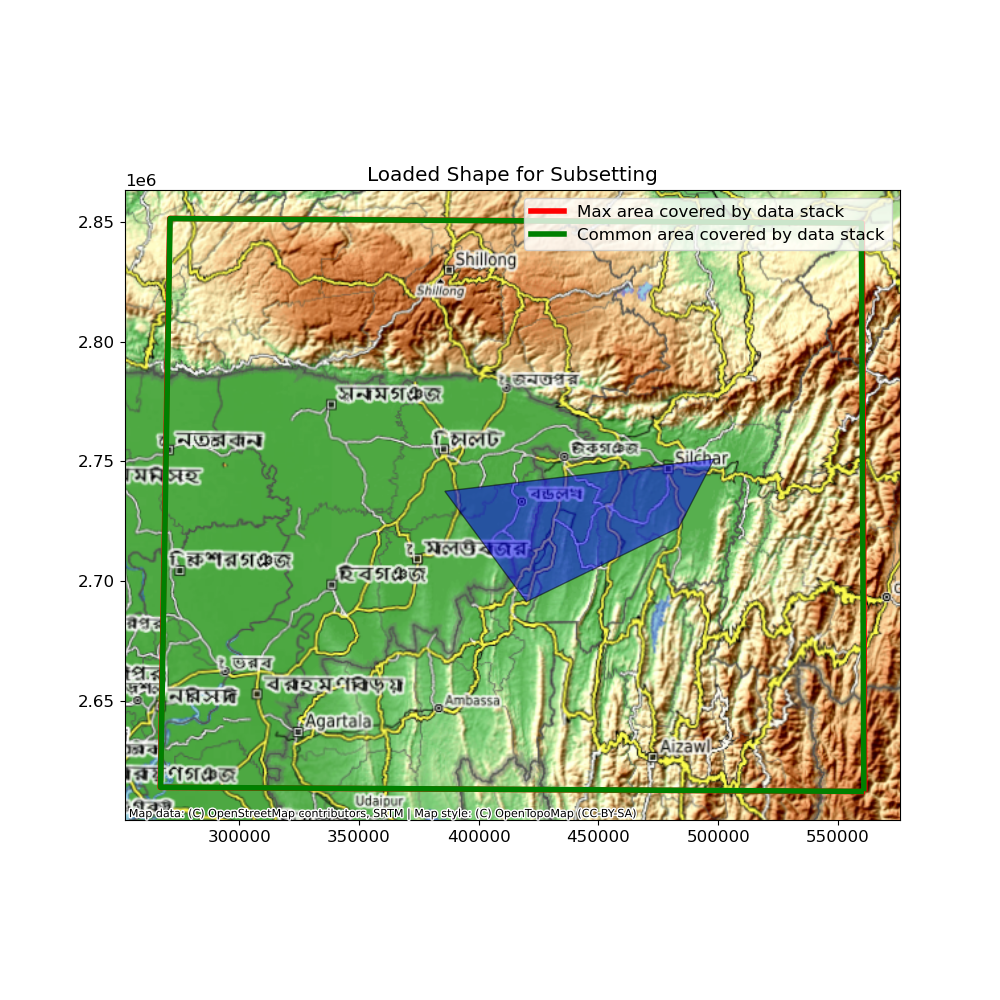

Max area covered by data stack: Every pixel guaranteed to be present in at least 1 image
Common area covered by data stack: Every pixel guaranteed to be present in all images


In [7]:
if not draw and not wkt_poly:
    shp_path = Path(shp_fc.selected)
    if shp_path.suffix != '.shp':
        raise Exception(f'Selected file suffix not ".shp"')
if not draw:   
    shp_gdf = gpd.read_file(shp_path)

    box1 = gpd.GeoDataFrame({"geometry": [box(*max_extents)]}, crs='EPSG:3857')
    box2 = gpd.GeoDataFrame({"geometry": [box(*common_extents)]}, crs='EPSG:3857')
    box1 = box1.to_crs(crs=shp_gdf.crs.to_string())
    box2 = box2.to_crs(crs=shp_gdf.crs.to_string())
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    shp_gdf.plot(ax=ax, color='blue', alpha=0.5, edgecolor='k')
    box1.plot(ax=ax, color='none', edgecolor='red', linewidth=4)
    box2.plot(ax=ax, color='none', edgecolor='green', linewidth=4)
    
    ctx.add_basemap(ax, crs=shp_gdf.crs.to_string(), source=ctx.providers.OpenTopoMap)
    
    minx, miny, maxx, maxy = box1.total_bounds
    buffer_percentage = 0.05
    buffer_x = (maxx - minx) * buffer_percentage
    buffer_y = (maxy - miny) * buffer_percentage
    buffered_minx = minx - buffer_x
    buffered_maxx = maxx + buffer_x
    buffered_miny = miny - buffer_y
    buffered_maxy = maxy + buffer_y
    
    ax.set_xlim(buffered_minx, buffered_maxx)
    ax.set_ylim(buffered_miny, buffered_maxy)
    ax.set_title('Loaded Shape for Subsetting')
    
    legend_elements = [
        Line2D([0], [0], color='red', lw=4, label='Max area covered by data stack'),
        Line2D([0], [0], color='green', lw=4, label='Common area covered by data stack')
    ]
    ax.legend(handles=legend_elements)
    plt.show()
    print('Max area covered by data stack: Every pixel guaranteed to be present in at least 1 image')
    print('Common area covered by data stack: Every pixel guaranteed to be present in all images')

---
## 6. Subset the data

In [8]:
for pth in tqdm(gdf['file']):
    print(f'Subsetting: {pth}')

    if draw:
        try:
            xmin, ymin, xmax, ymax = transform_bounds(
                3857,
                int(gdf['EPSG'].iloc[0]), 
                *[aoi.x1, aoi.y1, aoi.x2, aoi.y2]
            )
            ul = [xmin, ymax]
            lr = [xmax, ymin]
        except TypeError:
            print('TypeError')
            display(Markdown(f'<text style=color:red>This error may occur if an AOI was not selected.</text>'))
            display(Markdown(f'<text style=color:red>Note that the square tool icon in the AOI selector menu is <b>NOT</b> the selection tool. It is the zoom tool.</text>'))
        temp_pth = pth.parent/f'subset_{pth.name}'
        gdal.Translate(destName=temp_pth, srcDS=pth, projWin=[ul[0], ul[1], lr[0], lr[1]])
        pth.unlink()
        temp_pth.rename(pth)
    else:
        warp_args = gdal.WarpOptions(cutlineDSName=shp_path, cropToCutline=True) 
        gdal.Warp(pth, pth, options=warp_args)

  0%|          | 0/16 [00:00<?, ?it/s]

Subsetting: /home/jovyan/bang4/VH/S1A_IW_20180709T234718_DVP_RTC30_G_gpuned_9471_VH.tif
Subsetting: /home/jovyan/bang4/VH/S1A_IW_20180721T234719_DVP_RTC30_G_gpuned_86ED_VH.tif
Subsetting: /home/jovyan/bang4/VH/S1A_IW_20180802T234719_DVP_RTC30_G_gpuned_BABE_VH.tif
Subsetting: /home/jovyan/bang4/VH/S1A_IW_20180814T234720_DVP_RTC30_G_gpuned_DA3A_VH.tif
Subsetting: /home/jovyan/bang4/VH/S1A_IW_20180826T234721_DVP_RTC30_G_gpuned_19B6_VH.tif
Subsetting: /home/jovyan/bang4/VH/S1A_IW_20180907T234721_DVP_RTC30_G_gpuned_0692_VH.tif
Subsetting: /home/jovyan/bang4/VH/S1A_IW_20180919T234722_DVP_RTC30_G_gpuned_8784_VH.tif
Subsetting: /home/jovyan/bang4/VH/S1A_IW_20181001T234722_DVP_RTC30_G_gpuned_3704_VH.tif
Subsetting: /home/jovyan/bang4/VV/S1A_IW_20180709T234718_DVP_RTC30_G_gpuned_9471_VV.tif
Subsetting: /home/jovyan/bang4/VV/S1A_IW_20180721T234719_DVP_RTC30_G_gpuned_86ED_VV.tif
Subsetting: /home/jovyan/bang4/VV/S1A_IW_20180802T234719_DVP_RTC30_G_gpuned_BABE_VV.tif
Subsetting: /home/jovyan/bang4/V

*Subset_HydroSAR_Stack.ipynb - Version 1.0.0 - May 2024*